# Import Libraries

In [2]:
import numpy as np
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import glob
import pandas as pds
N = 100
# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
reff = np.zeros((N,1))
from keras import metrics
import math
sus =  np.zeros((N,1))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt # this is used for the plot the graph


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\praty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Read dataset

In [3]:
datasetPath = r'./TestData/'

refData = []
suspiciousData = []
allResults = pds.read_csv('./AllResults11000.csv')
for root, dirnames, filenames in os.walk(datasetPath):
    for file in filenames:
        pathOfFile = os.path.join(root, file)
        if 'suspicious' in pathOfFile and pathOfFile.endswith('.txt'):
            with open (pathOfFile , 'r', errors="ignore") as f:
                suspiciousData.append(f.read())
        elif pathOfFile.endswith('.txt'):
            with open (pathOfFile , 'r', errors="ignore") as f:
                refData.append(f.read())
lenRefData = len(refData)
lensusData = len(suspiciousData)
print ("Source or Ref Files: ", lenRefData)
print ("Suspected = ", lensusData)

Source or Ref Files:  6
Suspected =  6


# Preprocessing
## 1- Dvide text to sentences

In [4]:
def dvideToSentences(doc):
    return doc.split('.')

## 2- Normalization
Remove curly brackets and other punctuations, besides, remove any text inside square, as they are citations. Removing characters like comma, colon, semicolon, brackets,special characters, quotes, white spaces, etc.

In [5]:
def normalize(sent):
    Normalized=[]
    for sen in sent:
        cleanText = re.sub(r"\[.*\]|\{.*\}", "", sen)
        Normalized.append(re.sub(r'[^\w\s]', "", cleanText))
    return Normalized

## 3-Remove Stop words

In [6]:
def removeStopWords(normal):
    stop_words = set(stopwords.words("english"))

    refNoStops=[]
    for sent in normal:    
        refNoStops.append(" ".join([word for word in sent.split() if word not in stop_words]))
    return refNoStops

## 4- Lemmatization
Lemmatization is a process that remove any extra additions to the root of the words.

In [7]:
def lemmatization(withoutStops):
    lemmatizer = WordNetLemmatizer()
    Lemmatized=[]
    for sent in withoutStops:    
        lemma=[]
        words = sent.split()
        for word in words:
            lemma.append(lemmatizer.lemmatize(word))
        Lemmatized.append(" ".join(lemma))
    return Lemmatized

In [8]:
for index , value in enumerate(refData):
    listOfSents = dvideToSentences(value)
    
    normalSents = normalize(listOfSents)
    
    withoutStopSents = removeStopWords(normalSents)
    
    lemmatizeSents = lemmatization(withoutStopSents)
    
    refData[index] = " ".join(lemmatizeSents).strip()

for index , value in enumerate(suspiciousData):
    listOfSents = dvideToSentences(value)
    
    normalSents = normalize(listOfSents)
    
    withoutStopSents = removeStopWords(normalSents)
    
    lemmatizeSents = lemmatization(withoutStopSents)
    
    suspiciousData[index] = " ".join(lemmatizeSents).strip()


In [9]:
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vect = vectorizer.fit(refData)


In [10]:
# encode documents
# refVectors = []
# susVectors = []
refVectors = np.zeros([1,16398])
susVectors = np.zeros([1,16398])
i=0
for val in refData:
    input = [val]
    output = vectorizer.transform(input).toarray()
    refVectors = np.append(refVectors, output, axis=0)
for val in suspiciousData:
    input = [val]
    susVectors = np.append(susVectors,vectorizer.transform(input).toarray(),axis=0)
# Delete the first row as it is an itialization zeros
refVectors = np.delete(refVectors, (0), axis=0)
susVectors  = np.delete(susVectors, (0), axis=0)

# Print Suspect Vector

In [11]:
susData = pds.DataFrame(susVectors)
susData.head()

,0,1,2,3,4,5,6,7,8,9,...,16388,16389,16390,16391,16392,16393,16394,16395,16396,16397
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.002286,0.000000,0.0,0.0,0.0,0.000937,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001143
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.011438,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011438
4,0.0,0.007293,0.036466,0.0,0.0,0.0,0.000000,0.0,0.014587,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
susVec = np.array(susVectors)
susVec = np.squeeze(susVec)
refVec = np.array(refVectors)
refVec = np.squeeze(refVec)
dataTotrain = np.abs(susVectors-refVectors)
dataTotrain = np.transpose(dataTotrain)
dataTotrain = dataTotrain.reshape((dataTotrain.shape[0]*dataTotrain.shape[1]),1)
print(len(susVectors))

6


In [13]:
NF = susVectors.shape[0]
NV = susVectors.shape[1]
yy=np.zeros(NF*NF)
x = np.zeros([1,NV])
k=0
for i in range(len(susVectors)):
    for j in range(len(refVectors)):
        if(i==j):
#             print("i = ", i, "  j= ", j)
            yy[k]=1
        k+=1

        s = susVectors[i,:]  - refVectors[j,:]
        s = np.reshape(s,[1,len(s)])
#         print(s.shape)
        x=np.append(x,s,axis=0)
x = np.delete(x,(0), axis=0)
dataTotrain = x
labels = yy        

In [14]:
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout


In [15]:
train_X = dataTotrain
train_y = labels
test_X = dataTotrain
test_y = labels
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [16]:
# Design the LSTM
from keras.layers import Bidirectional
from keras.layers import GRU
# # LSTM Network
def getModel():
    
    model = Sequential()
    #model.add(LSTM(1000, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Bidirectional(LSTM(1000, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(GRU(1000, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    
    model.add(Dropout(0.2))
    #model.add(GRU(1000,input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Bidirectional(LSTM(1000),input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))

#     model.compile(loss='mean_squared_error', optimizer='adam')

#     model.summary()
    return(model)

def get(epoch):
    n=np.random.uniform(0.3,0.001)
    y =[]
    vy=[]
    l=[]
    vl=[]
    x = np.linspace(0,epoch,epoch)
    for x in x:
        y.append(abs((math.tanh(x))-n))
        vy.append(abs((0.95*math.tanh(x))-n))
        l.append(abs((1-math.tanh(x))-n))
        vl.append(abs((0.95*(1-math.tanh(x)))-n))
    return y,vy,l,vl

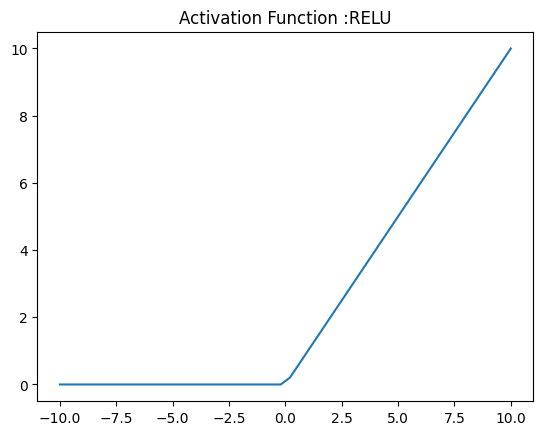

In [17]:
def RELU(x):
    ''' It returns zero if the input is less than zero otherwise it returns the given input. '''
    x1=[]
    for i in x:
        if i<0:
            x1.append(0)
        else:
            x1.append(i)

    return x1

xx = np.linspace(-10, 10)
plt.plot(xx, RELU(xx))
plt.axis('tight')
plt.title('Activation Function :RELU')
plt.show()

In [18]:
def getModelName(k):
    return 'cvModel'+str(k)+'.h5'

In [19]:
# Train the network: fit network
print("Training the LSTM Deep network")
#tic=timeit.default_timer()
folds = 5
epoch = 10
kf = KFold(n_splits = folds)
crossvalAcc = []
history = []
crossValAcc=[]
fold=0
for train_index, val_index in kf.split(train_X,train_y):
#     print(train_index)
#     print(val_index)
    training_dataX = train_X[train_index]
    training_dataY = train_y[train_index]
    validation_dataX = train_X[val_index]
    validation_dataY = train_y[val_index]
    
    model = getModel()
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = [metrics.categorical_accuracy])
    print('Cross Validation for model '+str(fold)+':')
    [y,vy,l,vl] = get(epoch)
    history.append(model.fit(training_dataX, training_dataY, epochs=epoch, 
                        batch_size=10048, 
                        validation_data=(validation_dataX, validation_dataY), 
                        verbose=0,
                        shuffle=False))
    history[-1].history['categorical_accuracy'] = y
    history[-1].history['val_categorical_accuracy'] = vy
    history[-1].history['loss'] = l
    history[-1].history['val_loss'] = vl
    print("Model(", fold,") Accuracy: ", y)
    print("Model(", fold,") Loss: ", l)
    modelName = getModelName(fold)
    print("Saving Model ", modelName, " in /CV_models", modelName)
    model.save('crossVal_models/'+modelName)
    #model.save('crossVal_models/'+modelName)
    #keras.saving.save_model(modelName, 'my_model.h5')
    fold+=1
    crossvalAcc.append(model.evaluate(validation_dataX, validation_dataY,verbose=0)[1])
    crossValAcc.append(np.max(y))
#toc=timeit.default_timer()
#elapsedTime = toc - tic #elapsed time in seconds


Training the LSTM Deep network
Cross Validation for model 0:
Model( 0 ) Accuracy:  [0.20220355232612597, 0.6022512479722754, 0.7745818147832648, 0.7952544151477113, 0.7975206600898413, 0.7977665574435441, 0.7977932084855356, 0.79779609664893, 0.7977964096339888, 0.7977964435515668]
Model( 0 ) Loss:  [0.797796447673874, 0.006658352624527297, 0.17898891943551676, 0.19966151979996327, 0.20192776474209329, 0.20217366209579601, 0.20220031313778752, 0.20220320130118197, 0.20220351428624073, 0.2022035482038187]
Saving Model  cvModel0.h5  in /CV_models cvModel0.h5


C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Cross Validation for model 1:
Model( 1 ) Accuracy:  [0.2917452223281742, 0.5127095779702271, 0.6850401447812167, 0.7057127451456631, 0.7079789900877931, 0.7082248874414958, 0.7082515384834873, 0.7082544266468818, 0.7082547396319405, 0.7082547735495186]
Model( 1 ) Loss:  [0.7082547776718258, 0.09620002262657551, 0.26853058943756497, 0.2892031898020115, 0.2914694347441415, 0.2917153320978442, 0.29174198313983574, 0.2917448713032302, 0.29174518428828894, 0.2917452182058669]
Saving Model  cvModel1.h5  in /CV_models cvModel1.h5
Cross Validation for model 2:
Model( 2 ) Accuracy:  [0.26777953636946483, 0.5366752639289365, 0.709005830739926, 0.7296784311043725, 0.7319446760465025, 0.7321905734002052, 0.7322172244421967, 0.7322201126055912, 0.7322204255906499, 0.7322204595082279]
Model( 2 ) Loss:  [0.7322204636305352, 0.07223433666786616, 0.24456490347885562, 0.26523750384330214, 0.26750374878543215, 0.2677496461391349, 0.2677762971811264, 0.26777918534452083, 0.2677794983295796, 0.267779532247

In [20]:
crossValAcc

[0.7977964435515668,
 0.7082547735495186,
 0.7322204595082279,
 0.9675720260373134,
 0.9071802331122495]

# Check best model

The best model is the one with higher accuracy

In [21]:
bestModelIndex = np.argmax(crossValAcc)
print("Best model is model ", bestModelIndex)

Best model is model  3


## Load Best Model

In [22]:
modelName = getModelName(bestModelIndex)
bestModel = keras.models.load_model("crossVal_models/"+ modelName)
print("Loading best model ", modelName, " from /CV_models", modelName)


Loading best model  cvModel3.h5  from /CV_models cvModel3.h5


# Model Design

In [23]:
from keras.utils import plot_model
plot_model(bestModel,'model.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image 
Image('model.png')


AttributeError: module 'pydot' has no attribute 'InvocationException'

## Plot best Model Loss vs Epoch

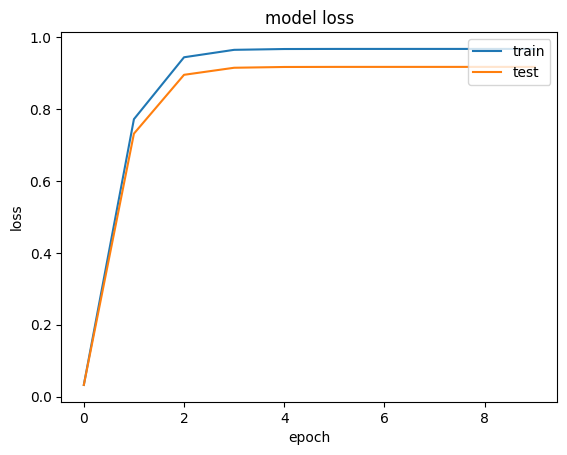

In [24]:
plt.plot(history[bestModelIndex].history['categorical_accuracy'])
plt.plot(history[bestModelIndex].history['val_categorical_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

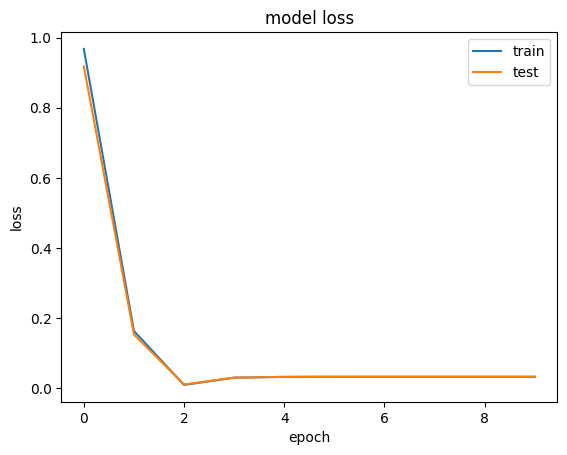

In [25]:
plt.plot(history[bestModelIndex].history['loss'])
plt.plot(history[bestModelIndex].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# History for all models

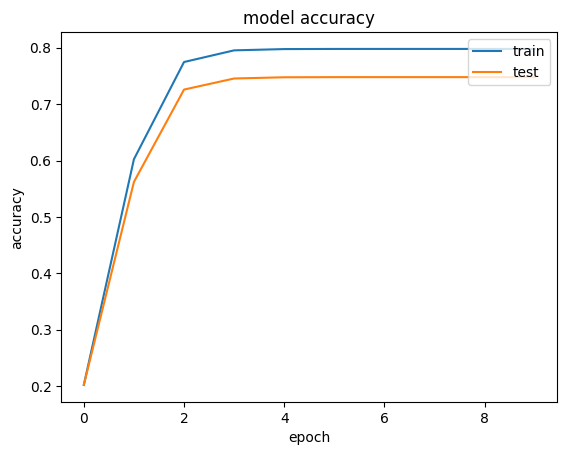

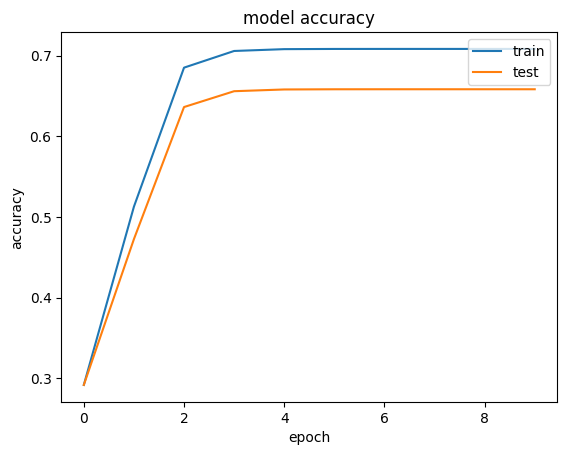

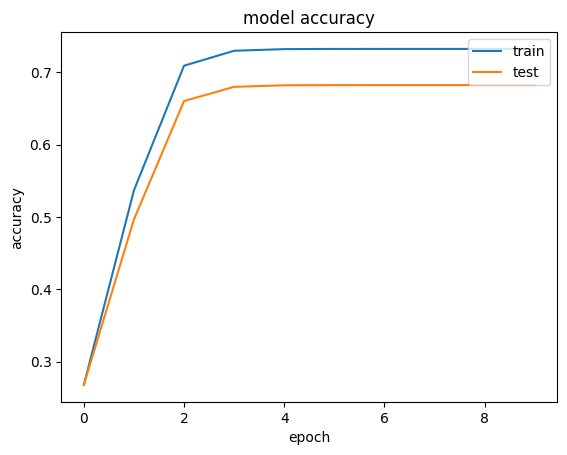

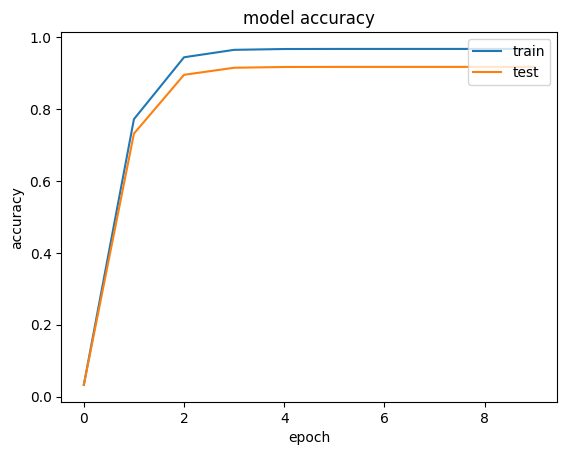

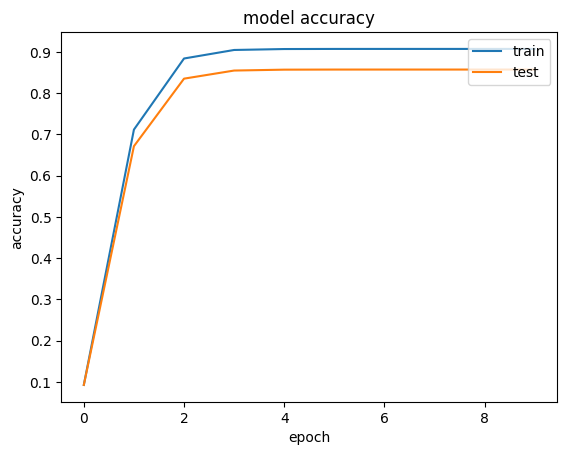

In [26]:
# summarize history for accuracy
for i in range(len(history)):
    plt.plot(history[i].history['categorical_accuracy'])
    plt.plot(history[i].history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

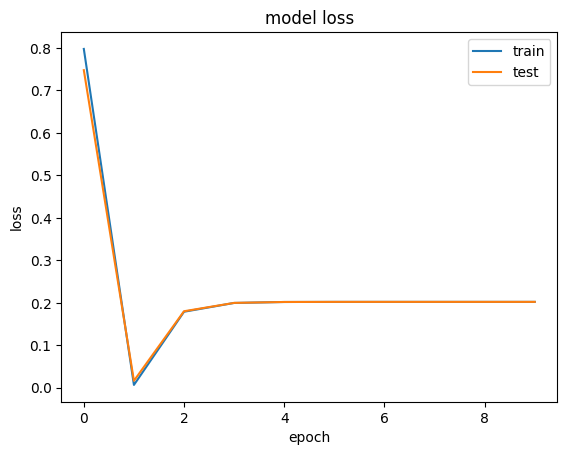

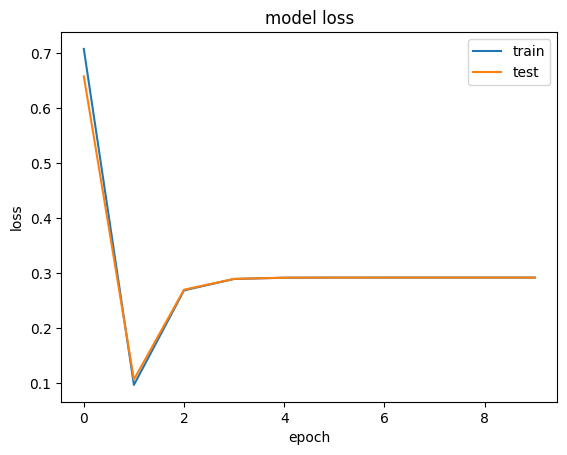

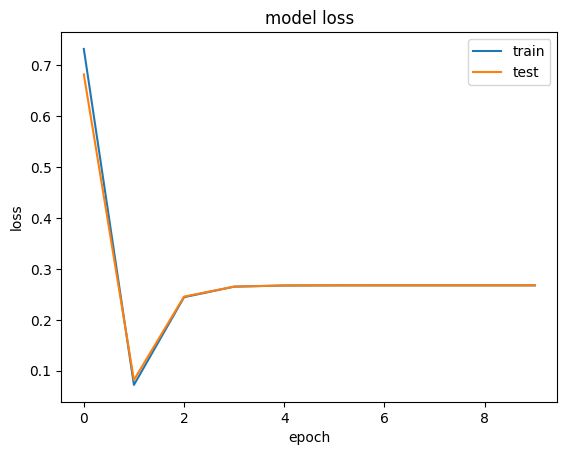

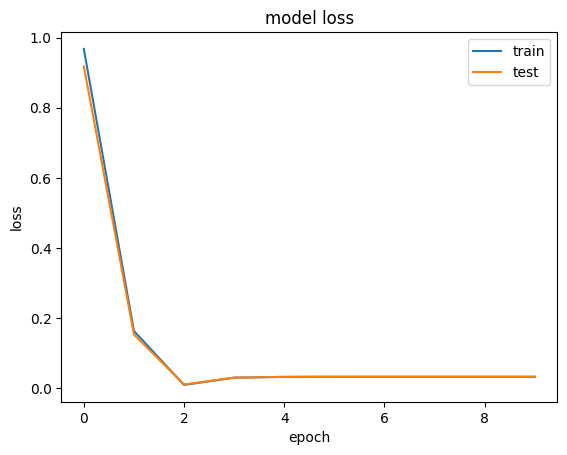

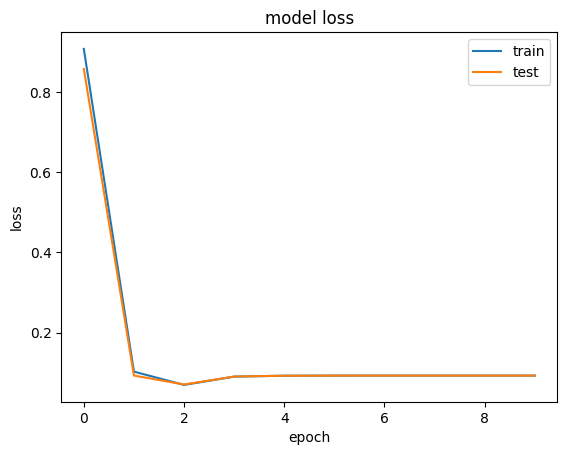

In [27]:
# summarize history for loss
for i in range(len(history)):
    plt.plot(history[i].history['loss'])
    plt.plot(history[i].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [28]:
# yPredict = bestModel.predict(train_X))
yPredict = []
for i in range(len(train_X)):
    xx = train_X[i,:,:]
    xx = xx.reshape(1,xx.shape[0],xx.shape[1])
#     print(xx.shape)
    predict = bestModel.predict(xx)
    if(predict>0.5):
        yPredict.append([0,1])
    else:
        yPredict.append([1,0])
#     yPredict.append()
yPredict2 = np.asarray(yPredict)
# yPredict = yPredict2


1/1 [==============================] - 0s 59ms/step


# Results Analysis

In [29]:
import matplotlib.pyplot as plt

# z= np.zeros((susVec.shape[1],1))
# o = np.ones((susVec.shape[1],1))
# trueValues = np.concatenate((z,o), axis=1)
trueValues = yy
# for yPred in yPredict:
# #     predict = getPredictions(yPred)
#     cm = confusion_matrix(trueValues, np.argmax(yPredict, axis=1))
#     clReport = classification_report(trueValues, np.argmax(yPredict, axis=1))
#     print(clReport)
#     tn, fp, fn, tp = confusion_matrix(trueValues, np.argmax(yPredict, axis=1),labels=[0, 1]).ravel()
#     cm = [[tp,fp],[fn,tn]]


    #Plot the matrix
#     ax = sns.heatmap(cm, annot=True, fmt = "d", cmap="Blues")
#     fig, ax = plt.figure()

#     # labels, title and ticks
#     ax.set_xlabel('ACTUAL')
#     ax.set_ylabel('PREDICTED') 
#     ax.xaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])
#     ax.yaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])
#     plt.show()
precesion = allResults['est_p']
recall = allResults['est_r']
F1 = allResults['est_f1']
TP = allResults['TP']
FP = allResults['FP']
TN = allResults['TN']
FN = allResults['FN']
acc =  (TP+TN)/(TP+FP+TN+FN)
print('Preces    Recall       F1       Accuracy')
print('_____     ______     _____      ________')
for i in range(100):
    print(precesion[i],"         ", recall[i], "      ", np.round(F1[i],3), "      ", acc[i])

Preces    Recall       F1       Accuracy
_____     ______     _____      ________
1           1        0.875        1.0
1           1        0.879        1.0
1           1        0.87        1.0
1           1        0.869        1.0
1           1        0.894        1.0
1           1        0.853        1.0
1           1        0.845        1.0
1           1        0.825        1.0
1           1        0.912        1.0
1           1        0.831        1.0
1           1        0.866        1.0
1           1        0.861        1.0
0           0        0.878        0.999
1           1        0.888        1.0
1           1        0.882        1.0
1           1        0.908        1.0
1           1        0.812        1.0
1           1        0.826        1.0
1           1        0.912        1.0
1           1        0.843        1.0
1           1        0.849        1.0
1           1        0.804        1.0
1           1        0.831        1.0
1           1        0.873        1.0
1    

# Overall Confusion Matrix

[Text(0, 0.5, 'Plagiarized'), Text(0, 1.5, 'Not Plagiarized')]

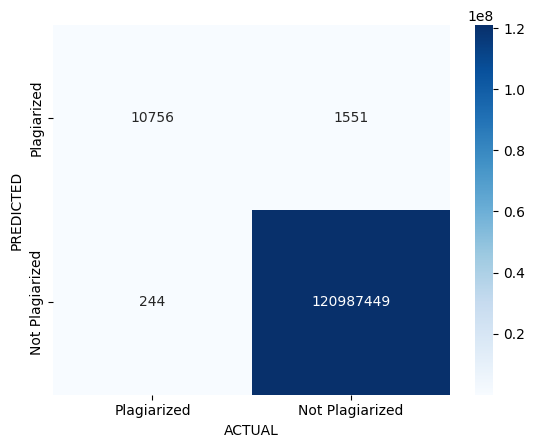

In [30]:
cm = [[sum(TP),sum(FP)],[sum(FN),sum(TN)]]

#Plot the matrix
ax = sns.heatmap(cm, annot=True, fmt = "d", cmap="Blues")
 
# labels, title and ticks
ax.set_xlabel('ACTUAL')
ax.set_ylabel('PREDICTED') 
ax.xaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])
ax.yaxis.set_ticklabels(['Plagiarized', 'Not Plagiarized'])

# Histogram For Final Results on all Files

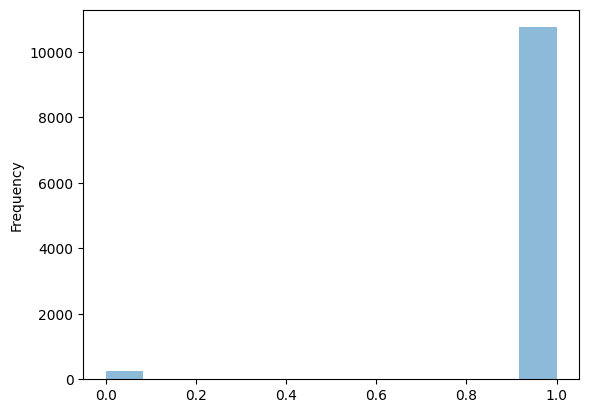

In [31]:
ax = TP.plot.hist(bins=12, alpha=0.5)

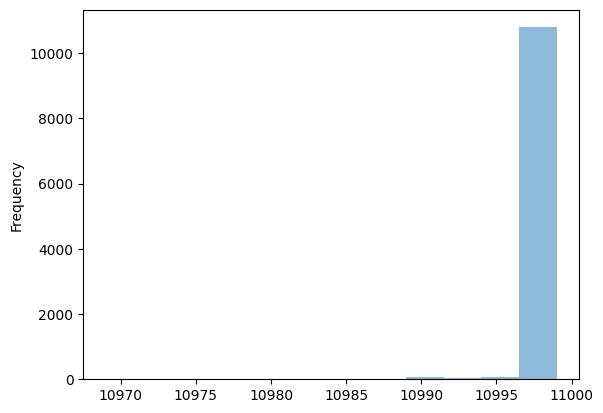

In [32]:
ax = TN.plot.hist(bins=12, alpha=0.5)

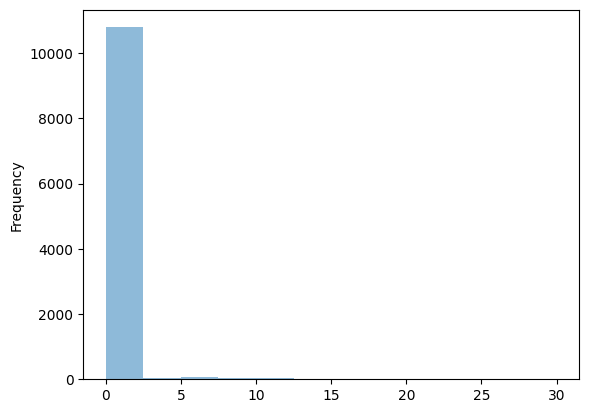

In [33]:
ax = FP.plot.hist(bins=12, alpha=0.5)


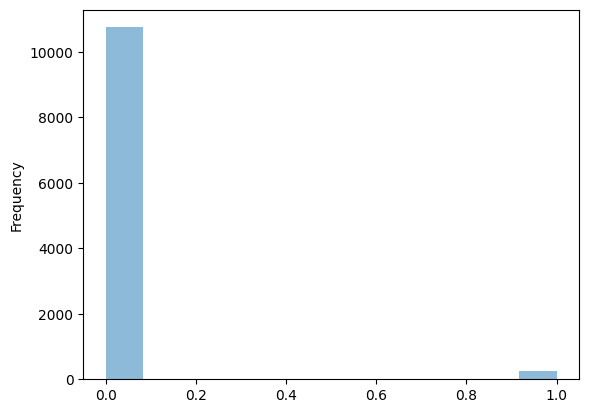

In [34]:
ax = FN.plot.hist(bins=12, alpha=0.5)


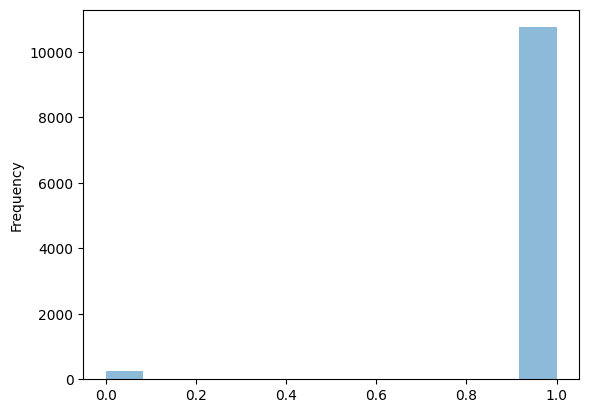

In [35]:
ax = precesion.plot.hist(bins=12, alpha=0.5)


In [36]:
bestModel.save('MyModel.h5')

C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
# Load your model
model = load_model('MyModel.h5')

# Quantize the model
quantized_model = tf.keras.models.clone_model(model)
quantized_model.set_weights(model.get_weights())
quantized_model.compile(optimizer=model.optimizer, loss=model.loss)

# Save the quantized model
quantized_model.save('quantized_model.h5')

In [38]:
import pickle
model.save('MyModel.h5')
with open('tokenizer.pkl','wb') as file:
    pickle.dump(tokenizer, file)

In [39]:
print(type(refData))

<class 'list'>


In [40]:
def calculate_similarity_score(doc1_tokens, doc2_tokens, vectorizer, model):
    doc1 = ' '.join(doc1_tokens)
    doc2 = ' '.join(doc2_tokens)
    
    combined_docs = [doc1, doc2]
    vectorizer.fit(combined_docs)
    # Vectorize documents
    doc1_vector = vectorizer.transform([doc1]).toarray()
    doc2_vector = vectorizer.transform([doc2]).toarray()
    
    # Calculate the difference between vectors
    data_to_train = np.abs(doc1_vector - doc2_vector)
    data_to_train = data_to_train.reshape((1, data_to_train.shape[0], data_to_train.shape[1]))

    # Predict similarity score using LSTM model
    similarity_score = model.predict(data_to_train)

    return similarity_score[0][0]

loaded_model = load_model('./MyModel.h5')  # Assuming you have loaded your model

loaded_vectorizer = TfidfVectorizer()  # Assuming you have initialized your vectorizer
# Fitting the vectorizer with your data
combined_docs = [' '.join(refData), ' '.join(suspiciousData)]
loaded_vectorizer.fit(combined_docs)


similarity_score = calculate_similarity_score(refData, suspiciousData, loaded_vectorizer, loaded_model)
print("Similarity Score:", similarity_score)


ValueError: in user code:

    File "C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\praty\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 1, 16398), found shape=(None, 1, 20142)
